### Продакт-менеджер Василий попросил вас проанализировать завершенные уроки. 

#### Для решения задачи проведи предварительное исследование данных и сформулируй, что должно считаться курсом. Обосновать свой выбор ты можешь с помощью фактов сдачи экзаменов, распределения студентов и уникальный идентефикатор курса.

#### *завершаемость = кол-во успешных экзаменов / кол-во всех попыток сдать экзамен

#### Импортируем необходимые библиотеки

In [115]:
import pandas as pd
import numpy as np
import seaborn as sns
import requests
import json
from urllib.parse import urlencode
import matplotlib.pyplot as plt

#### Работаем с АПИ

In [19]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
marks = 'https://disk.yandex.ru/d/PBW7aUHGuodFDA'
courses = 'https://disk.yandex.ru/d/m0Z6QYNT46f9tQ'
results = 'https://disk.yandex.ru/d/lsmdbYB0iM7p3w'
registration = 'https://disk.yandex.ru/d/Yse4Y6RJqg_WaA'

#### Получаем загрузочные ссылки

In [20]:
marks_url = base_url + urlencode(dict(public_key=marks))
courses_url = base_url + urlencode(dict(public_key=courses))
results_url = base_url + urlencode(dict(public_key=results))
registration_url = base_url + urlencode(dict(public_key=registration))

#### загружаем ссылки

In [21]:
# ссылка на таблицу с информацией об оценках в тесте
marks_response = requests.get(marks_url)
marks_download_url = marks_response.json()['href']
marks_download_response = requests.get(marks_download_url)

# ссылка на таблицу со списоком предметов по семестрам.
courses_response = requests.get(courses_url)
courses_download_url = courses_response.json()['href']
courses_download_response = requests.get(courses_download_url)

# ссылка на таблицу с результатами тестов студентов
results_response = requests.get(results_url)
results_download_url = results_response.json()['href']
results_download_response = requests.get(results_download_url)

# ссылка на таблицу с информацией о времени, когда студент зарегистрировался для прохождения курса в семестре.
registration_response = requests.get(registration_url)
registration_download_url = registration_response.json()['href']
registration_download_response = requests.get(registration_download_url)

#### присваиваем переменным датасеты

In [22]:
marks = pd.read_csv(marks_download_url)
courses = pd.read_csv(courses_download_url)
results = pd.read_csv(results_download_url)
registration = pd.read_csv(registration_download_url)

#### Моя формулировка курса:

## Курс - один предмет, Успешная сдача курса - набрать не менее 40 баллов за экзамен  

### Информация об оценках в тесте. 
##### Обычно каждый предмет в семестре включает ряд тестов с оценками, за которыми следует заключительный экзаменационный тест
code_module — идентификационный код предмета.

code_presentation — семестр (Идентификационный код).

id_assessment — тест (Идентификационный номер ассессмента).

assessment_type — тип теста. Существуют три типа оценивания: оценка преподавателя (TMA), компьютерная оценка (СМА), экзамен по курсу (Exam).

date — информация об окончательной дате сдачи теста. Рассчитывается как количество дней с момента начала семестра. Дата начала семестра имеет номер 0 (ноль).

weight — вес теста в % в оценке за курс. Обычно экзамены рассматриваются отдельно и имеют вес 100%; сумма всех остальных оценок составляет 100%.

In [28]:
marks

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0
3,AAA,2013J,1755,TMA,166.0,20.0
4,AAA,2013J,1756,TMA,215.0,30.0
...,...,...,...,...,...,...
201,GGG,2014J,37443,CMA,229.0,0.0
202,GGG,2014J,37435,TMA,61.0,0.0
203,GGG,2014J,37436,TMA,124.0,0.0
204,GGG,2014J,37437,TMA,173.0,0.0


### список предметов по семестрам.
code_module — предмет (идентификационный код).

code_presentation — семестр (идентификационный код).

module_presentation_length — продолжительность семестра в днях.

In [29]:
courses

,code_module,code_presentation,module_presentation_length
0,AAA,2013J,268
1,AAA,2014J,269
2,BBB,2013J,268
3,BBB,2014J,262
4,BBB,2013B,240
5,BBB,2014B,234
6,CCC,2014J,269
7,CCC,2014B,241
8,DDD,2013J,261
9,DDD,2014J,262


### результаты тестов студентов. 
##### Если учащийся не отправляет работу на оценку, результат не записывается в таблицу.
id_assessment — тест (идентификационный номер).

id_student — идентификационный номер студента.

date_submitted — дата сдачи теста студентом, измеряемая как количество дней с начала семестра.

is_banked — факт перезачета теста с прошлого семестра (иногда курсы перезачитывают студентам, вернувшимся из академического отпуска).

score — оценка учащегося в этом тесте. Диапазон составляет от 0 до 100. Оценка ниже 40 неудачная/неуспешная сдача теста.

In [30]:
results

,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0
2,1752,31604,17,0,72.0
3,1752,32885,26,0,69.0
4,1752,38053,19,0,79.0
...,...,...,...,...,...
173907,37443,527538,227,0,60.0
173908,37443,534672,229,0,100.0
173909,37443,546286,215,0,80.0
173910,37443,546724,230,0,100.0


### информация о времени, когда студент зарегистрировался для прохождения курса в семестре.
code_module — предмет (идентификационный код).

code_presentation — семестр (идентификационный код)

id_student — идентификационный номер студента.

date_registration — дата регистрации студента. Это количество дней, измеренное от начала семестра (например, отрицательное значение -30 означает, что студент зарегистрировался на прохождение курса за 30 дней до его начала).

date_unregistration — дата отмены регистрации студента с предмета. У студентов, окончивших курс, это поле остается пустым.

In [31]:
registration

,code_module,code_presentation,id_student,date_registration,date_unregistration
0,AAA,2013J,11391,-159.0,NaN
1,AAA,2013J,28400,-53.0,NaN
2,AAA,2013J,30268,-92.0,12.0
3,AAA,2013J,31604,-52.0,NaN
4,AAA,2013J,32885,-176.0,NaN
...,...,...,...,...,...
32588,GGG,2014J,2640965,-4.0,NaN
32589,GGG,2014J,2645731,-23.0,NaN
32590,GGG,2014J,2648187,-129.0,NaN
32591,GGG,2014J,2679821,-49.0,101.0


## 1. Сколько студентов успешно сдали только один курс? (Успешная сдача — это зачёт по курсу на экзамене) 

* оставим только те строки таблицы результатов, которые относятся к экзаменам

In [32]:
exam_results = results.merge(marks[marks.assessment_type == 'Exam'][['id_assessment']], how='inner', on='id_assessment')

* отбираем студентов, которые успешно закончили только один курс

In [33]:
exam_results.query('score >= 40')\ # оставляем  только те строки, где результаты > 40 (т. е. студент сдал экзамен)
            .groupby('id_student')\
            .agg({'id_assessment': 'count'})\ # для каждого студента считаем сколько экзаменов он сдал
            .reset_index()\
            .query('id_assessment == 1') # Оставляем только тех студентов, которые смогли сдать успешно только 1 предмет 

,id_student,id_assessment
0,23698,1
1,24213,1
2,27116,1
3,28046,1
4,28787,1
...,...,...
4092,2694886,1
4093,2694933,1
4094,2695608,1
4095,2697181,1


### Ответ: 3802 студентов единажды успешно завершили курс

### -------------------

### 2. Выяви самый сложный и самый простой экзамен: найди курсы и экзамены в рамках курса, которые обладают самой низкой и самой высокой завершаемостью*

#### *завершаемость = кол-во успешных экзаменов / кол-во всех попыток сдать экзамен

* Выбираем из таблицы результатов только результаты написания экзаменов

In [34]:
exam_results_with_code_module = results.merge(marks[marks.assessment_type == 'Exam'][['code_module', 'id_assessment']], how='inner', on='id_assessment')

* Считаем количество попыток сдать экзамен по всем предметам

In [35]:
all_exam_attempts = exam_results_with_code_module\
                        .groupby(['code_module', 'id_assessment'])\
                        .agg({'date_submitted': 'count'})\
                        .reset_index()\
                        .rename(columns={'date_submitted': 'attempts'})
all_exam_attempts

,code_module,id_assessment,attempts
0,CCC,24290,747
1,CCC,24299,1168
2,DDD,25340,602
3,DDD,25354,968
4,DDD,25361,524
5,DDD,25368,950


* Посчитаем успешные попытки сдать экзамен

In [36]:
success_exam_attempts = exam_results_with_code_module\
            .query('score >= 40')\
            .groupby(['code_module', 'id_assessment'])\
            .agg({'date_submitted': 'count'})\
            .reset_index()\
            .rename(columns={'date_submitted': 'succ_attempts'})
success_exam_attempts

,code_module,id_assessment,succ_attempts
0,CCC,24290,664
1,CCC,24299,1019
2,DDD,25340,504
3,DDD,25354,878
4,DDD,25361,485
5,DDD,25368,842


* Объединим таблицы и посчитаем завершаемость

In [37]:
df = success_exam_attempts.merge(all_exam_attempts, on=['code_module', 'id_assessment'])
df['completion'] = df.succ_attempts/df.attempts
df.sort_values('completion')

,code_module,id_assessment,succ_attempts,attempts,completion
2,DDD,25340,504,602,0.837209
1,CCC,24299,1019,1168,0.872432
5,DDD,25368,842,950,0.886316
0,CCC,24290,664,747,0.888889
3,DDD,25354,878,968,0.907025
4,DDD,25361,485,524,0.925573


### Ответ: самым сложным является экзамен с id 25340, а самым легким - с id 25361. Оба экзамена принадлежат одному курсу DDD

#### ------------------------------------


### 3. По каждому предмету определи средний срок сдачи экзаменов (под сдачей понимаем последнее успешное прохождение экзамена студентом)

* Выбираем из таблицы результатов только результаты написания экзаменов

In [38]:
df = results.merge(marks[marks.assessment_type == 'Exam'][['code_module', 'id_assessment']], on='id_assessment')
df

,id_assessment,id_student,date_submitted,is_banked,score,code_module
0,24290,558914,230,0,32.0,CCC
1,24290,559706,234,0,78.0,CCC
2,24290,559770,230,0,54.0,CCC
3,24290,560114,230,0,64.0,CCC
4,24290,560311,234,0,100.0,CCC
...,...,...,...,...,...,...
4954,25368,652680,243,0,91.0,DDD
4955,25368,652732,249,0,47.0,DDD
4956,25368,652965,242,0,87.0,DDD
4957,25368,653051,242,0,27.0,DDD


* Видим, что экзамены писали только по двум предметам

In [39]:
df.code_module.unique()

array(['CCC', 'DDD'], dtype=object)

* Посчитаем среднее количество дней, необходимых для сдачи предмета ССС, предварительно убрав дубликаты по студентам, оставляя только последнее успешное прохождение экзамена

In [40]:
CCC = df.query('score >= 40')\
            .sort_values('date_submitted', ascending=False)\
            .query('code_module == "CCC"')\
            .drop_duplicates(subset=['id_student'])\
            .groupby(['code_module'])\
            .agg({'date_submitted': 'mean'})
CCC

,date_submitted
code_module,
CCC,239.345217


* Посчитаем среднее количество дней, необходимых для сдачи предмета DDD, предварительно убрав дубликаты по студентам, оставляя только последнее успешное прохождение экзамена

In [41]:
DDD = df.query('score >= 40')\
            .sort_values('date_submitted', ascending=False)\
            .query('code_module == "DDD"')\
            .drop_duplicates(subset=['id_student'])\
            .groupby(['code_module'])\
            .agg({'date_submitted': 'mean'})
DDD

,date_submitted
code_module,
DDD,237.978566


### Ответ: для предмета CCC среднее - 239.345217, для DDD - 237.978566

#### ------------------------------------------------------------

### 4. Выяви самые популярные предметы (ТОП-3) по количеству регистраций на них. А также предметы с самым большим оттоком (ТОП-3)

* Определим самые популярные предметы по количеству регистраций

In [42]:
cool_subjects = registration.groupby('code_module')\
            .agg({'id_student': 'count'})\
            .reset_index()\
            .rename(columns={'id_student': 'registrations'})\
            .sort_values('registrations', ascending=False)\
            .head(3)

* Предметы с самым большим оттоком 

In [43]:
bad_subjects = registration.dropna(subset=['date_unregistration'])\
                    .groupby('code_module')\
                    .agg({'id_student': 'count'})\
                    .reset_index()\
                    .rename(columns={'id_student': 'registrations'})\
                    .sort_values('registrations', ascending=False)\
                    .head(3)
bad_subjects

,code_module,registrations
5,FFF,2380
1,BBB,2377
3,DDD,2235


### Ответ: самые популярные предметы по количеству регистраций оказались с самым большим оттоком (FFF, BBB, DDD)

### ------------------------------------------------------

### 5. Используя pandas, в период с начала 2013 по конец 2014 выяви семестр с самой низкой завершаемостью курсов и самыми долгими средними сроками сдачи курсов. 

* Возьмем все результаты студентов по экзаменам за семестр

In [44]:
df = results.merge(marks[marks.assessment_type == 'Exam'], on='id_assessment')

* Посмотрим за какие семестры мы имеем данные

In [45]:
df['code_presentation'].unique()

array(['2014B', '2014J', '2013B', '2013J'], dtype=object)

* Видим, что в данных содержатся только интересующие нас семестры

* Заведем колонку "credited" с результатом экзамена "True" - экзамен сдан, "False" - не сдан

In [46]:
df['credited'] = df['score'].apply(lambda x: True if x >= 40 else False)
df

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight,credited
0,24290,558914,230,0,32.0,CCC,2014B,Exam,NaN,100.0,False
1,24290,559706,234,0,78.0,CCC,2014B,Exam,NaN,100.0,True
2,24290,559770,230,0,54.0,CCC,2014B,Exam,NaN,100.0,True
3,24290,560114,230,0,64.0,CCC,2014B,Exam,NaN,100.0,True
4,24290,560311,234,0,100.0,CCC,2014B,Exam,NaN,100.0,True
...,...,...,...,...,...,...,...,...,...,...,...
4954,25368,652680,243,0,91.0,DDD,2014J,Exam,NaN,100.0,True
4955,25368,652732,249,0,47.0,DDD,2014J,Exam,NaN,100.0,True
4956,25368,652965,242,0,87.0,DDD,2014J,Exam,NaN,100.0,True
4957,25368,653051,242,0,27.0,DDD,2014J,Exam,NaN,100.0,False


* Считаем завершаемости семестров

In [47]:
credited_students = df.groupby('code_presentation')\
                        .agg({'credited': 'mean'})\ # среднее даст нам отношение сданных (Тrue) экзаменов к общему количеству экзаменов
                        .reset_index()
credited_students

,code_presentation,credited
0,2013B,0.837209
1,2013J,0.907025
2,2014B,0.904013
3,2014J,0.878659


* Найдем семестр с самой низкой завершаемостью

In [48]:
credited_students[credited_students.credited == credited_students.credited.min()]

,code_presentation,credited
0,2013B,0.837209


### Ответ 1: Семестр 2013B имеет самую низкую завершаемость по курсам

* Посчитаем средние сроки сдачи экзаменов по семестрам

In [49]:
avg_number_of_days = df.query('credited == True')\
                        .groupby('code_presentation')\
                        .agg({'date_submitted': 'mean'})\
                        .reset_index()\
                        .rename(columns={'date_submitted': 'avg_number_of_days'})
avg_number_of_days

,code_presentation,avg_number_of_days
0,2013B,230.164683
1,2013J,239.509112
2,2014B,232.997389
3,2014J,243.680279


In [50]:
avg_number_of_days[avg_number_of_days.avg_number_of_days == avg_number_of_days.avg_number_of_days.max()]

,code_presentation,avg_number_of_days
3,2014J,243.680279


### Ответ 2: Семестр 2014J имеет самый долгий средний срок сдачи экзамена

#### ------------------------------------------

### 6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй адаптированные RFM-кластеры студентов, чтобы качественно оценить свою аудиторию. В адаптированной кластеризации можешь выбрать следующие метрики: R - среднее время сдачи одного экзамена, F - завершаемость курсов, M - среднее количество баллов, получаемое за экзамен. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. 

R - среднее время сдачи одного экзамена
    
F - завершаемость курсов

M - среднее количество баллов

* Создаем датафрейм со всеми необходимыми данными

In [70]:
# объединяем таблицу оценок с таблицей результатов
res_marks = results.merge(marks[marks.assessment_type == 'Exam'][['code_module', 'id_assessment']], on='id_assessment')
# добавляем колонку, отражающую сдачу экзамена студентом
res_marks['credited'] = res_marks['score'].apply(lambda x: True if x >= 40 else False)
res_marks

,id_assessment,id_student,date_submitted,is_banked,score,code_module,credited
0,24290,558914,230,0,32.0,CCC,False
1,24290,559706,234,0,78.0,CCC,True
2,24290,559770,230,0,54.0,CCC,True
3,24290,560114,230,0,64.0,CCC,True
4,24290,560311,234,0,100.0,CCC,True
...,...,...,...,...,...,...,...
4954,25368,652680,243,0,91.0,DDD,True
4955,25368,652732,249,0,47.0,DDD,True
4956,25368,652965,242,0,87.0,DDD,True
4957,25368,653051,242,0,27.0,DDD,False


In [80]:
# Создаем датафрейм, сохраняя в нем только данные о студенте, среднем времени сдачи, завершаемости экзаменов и среднем балле
rfm = res_marks.groupby('id_student')\
        .agg({'date_submitted': 'mean', 'credited': 'mean', 'score': 'mean'})\
        .rename(columns={'date_submitted': 'mean_date', 'credited': 'completion', 'score': 'mean_score'})\
        .reset_index()
rfm

,id_student,mean_date,completion,mean_score
0,23698,243.0,1.0,80.0
1,24213,236.0,1.0,58.0
2,27116,243.0,1.0,96.0
3,28046,237.0,1.0,40.0
4,28787,243.0,1.0,44.0
...,...,...,...,...
4628,2694886,236.0,1.0,69.0
4629,2694933,230.0,1.0,73.0
4630,2695608,237.0,1.0,73.0
4631,2697181,230.0,1.0,80.0


In [81]:
# считаем квантили, чтобы разделять по ним студентов на сегменты
quintiles = rfm[['mean_date', 'completion', 'mean_score']].quantile([.2, .4, .6, .8]).to_dict()
quintiles

{'mean_date': {0.2: 231.0, 0.4: 237.0, 0.6: 242.0, 0.8: 243.5},
 'completion': {0.2: 1.0, 0.4: 1.0, 0.6: 1.0, 0.8: 1.0},
 'mean_score': {0.2: 46.200000000000045, 0.4: 60.0, 0.6: 72.0, 0.8: 84.0}}

In [82]:
rfm.completion.unique()

array([1. , 0. , 0.5])

##### Мы видим, что все квантили завершаемости одинаковы, но оно может принимать 3 состояния, разумнее, разделить на сегменты по ним

In [89]:
# Создаем функции для сегментации по каждой метрике
def r_score(x):
    if x <= quintiles['mean_date'][.2]:
        return 5
    elif x <= quintiles['mean_date'][.4]:
        return 4
    elif x <= quintiles['mean_date'][.6]:
        return 3
    elif x <= quintiles['mean_date'][.8]:
        return 2
    else:
        return 1
    
def f_score(x):
    if x == 1:
        return 3
    elif x == 0.5:
        return 2
    else:
        return 1

def m_score(x):
    if x <= quintiles['mean_score'][.2]:
        return 1
    elif x <= quintiles['mean_score'][.4]:
        return 2
    elif x <= quintiles['mean_score'][.6]:
        return 3
    elif x <= quintiles['mean_score'][.8]:
        return 4
    else:
        return 5

In [91]:
# Создаем колонки с оценками студентов по этим метрикам
rfm['R'] = rfm['mean_date'].apply(lambda x: r_score(x))
rfm['F'] = rfm['completion'].apply(lambda x: f_score(x))
rfm['M'] = rfm['mean_score'].apply(lambda x: m_score(x))
rfm.head()

,id_student,mean_date,completion,mean_score,R,F,M
0,23698,243.0,1.0,80.0,2,3,4
1,24213,236.0,1.0,58.0,4,3,2
2,27116,243.0,1.0,96.0,2,3,5
3,28046,237.0,1.0,40.0,4,3,1
4,28787,243.0,1.0,44.0,2,3,1


In [92]:
# объединяем оценки в один столбец
rfm['RFM Score'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)
rfm.head()

,id_student,mean_date,completion,mean_score,R,F,M,RFM Score
0,23698,243.0,1.0,80.0,2,3,4,234
1,24213,236.0,1.0,58.0,4,3,2,432
2,27116,243.0,1.0,96.0,2,3,5,235
3,28046,237.0,1.0,40.0,4,3,1,431
4,28787,243.0,1.0,44.0,2,3,1,231


Оценки RFM дают нам 5\*3\*5= 75 сегментов. С которым непросто работать.
Я собираюсь работать с 6 сегментами на основе оценок. Вот описание сегментов:

##### Ботан - быстро сдаёт экзамены, имеет высокую завершаемость и высокий средний балл
##### Отличник - умеренно сдаёт экзамены и имеет высокую завершаемость и высокий средний балл
##### Потенциальный отличник - имеет высокий средний балл
##### Хорошист - имеет высокую завершаемость и хороший средний балл
##### Потенциальный хорошист - имеет хороший средний балл
##### Троечник - имеет низкий средний балл


In [108]:
segt_map = {
    r'535': 'Ботан',
    r'[3-5]35': 'Отличник',
    r'[1-5][1-3]5': 'Потенциальный отличник',
    r'[3-5][1-3][4-5]': 'Хорошист',
    r'[1-5][1-3][4-5]': 'Потенциальный хорошист',
    r'[3-5][1-3][1-3]': 'Троечник',
    r'[1-5][1-3][1-3]': 'Двоечник'
}

In [109]:
rfm['Segment'] = rfm['RFM Score'].replace(segt_map, regex=True)
rfm

,id_student,mean_date,completion,mean_score,R,F,M,RFM Score,Segment
0,23698,243.0,1.0,80.0,2,3,4,234,Потенциальный хорошист
1,24213,236.0,1.0,58.0,4,3,2,432,Троечник
2,27116,243.0,1.0,96.0,2,3,5,235,Потенциальный отличник
3,28046,237.0,1.0,40.0,4,3,1,431,Троечник
4,28787,243.0,1.0,44.0,2,3,1,231,Двоечник
...,...,...,...,...,...,...,...,...,...
4628,2694886,236.0,1.0,69.0,4,3,3,433,Троечник
4629,2694933,230.0,1.0,73.0,5,3,4,534,Хорошист
4630,2695608,237.0,1.0,73.0,4,3,4,434,Хорошист
4631,2697181,230.0,1.0,80.0,5,3,4,534,Хорошист


([0, 1, 2, 3, 4, 5, 6], <a list of 7 Text major ticklabel objects>)

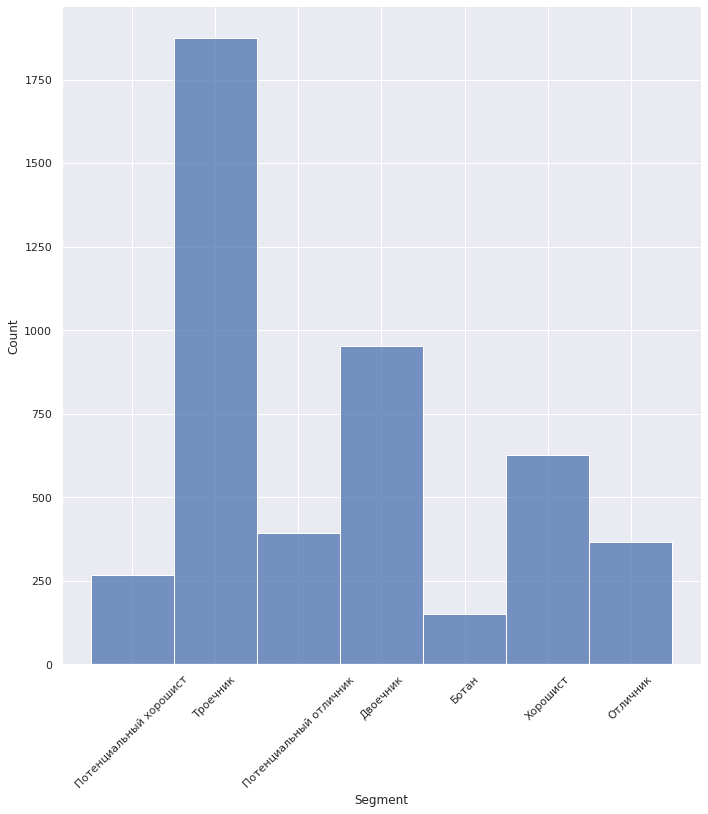

In [122]:
sns.displot(rfm.Segment, height = 10)
plt.xticks(rotation=45)